In [1]:
from plantcv import plantcv as pcv
import numpy as np
import cv2 as cv2

In [2]:
class options:
    def __init__(self):
        self.image = "C:/Users/Beth/Desktop/JL Lab/Egregious Pictures/Aww yikes/2019-07-10_1700(2).jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "./morphology_tutorial_results.txt"
        self.outdir = "."

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

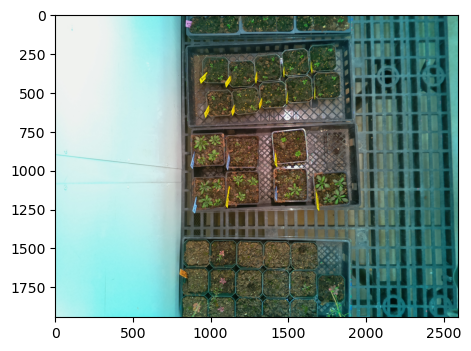

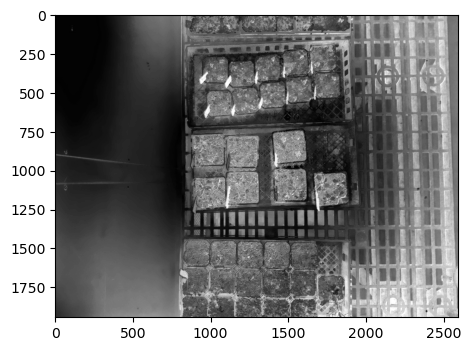

In [3]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

# Convert RGB to HSV and extract the saturation channel

# Inputs:
#   rgb_image - RGB image data 
#   channel - Split by 'h' (hue), 's' (saturation), or 'v' (value) channel
s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')



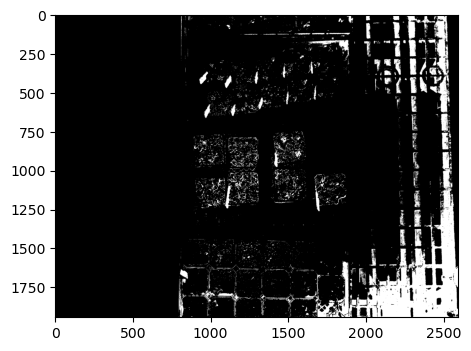

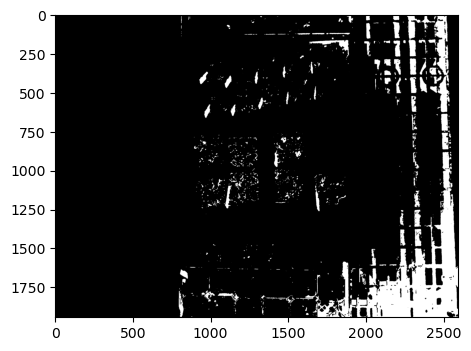

In [10]:
# Take a binary threshold to separate plant from background. 
# Threshold can be on either light or dark objects in the image. 

# Inputs:
#   gray_img - Grayscale image data 
#   threshold- Threshold value (between 0-255)
#   max_value - Value to apply above threshold (255 = white) 
#   object_type - 'light' (default) or 'dark'. If the object is lighter than 
#                 the background then standard threshold is done. If the object 
#                 is darker than the background then inverse thresholding is done. 
s_thresh = pcv.threshold.binary(gray_img=s, threshold=170, max_value=255, object_type='light')

# Median Blur to clean noise 

# Inputs: 
#   gray_img - Grayscale image data 
#   ksize - Kernel size (integer or tuple), (ksize, ksize) box if integer input,
#           (n, m) box if tuple input 
s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=5)



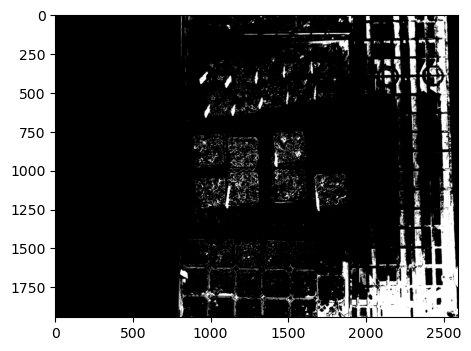

In [11]:
# An alternative to using median_blur is gaussian_blur, which applies 
# a gaussian blur filter to the image. Depending on the image, one 
# technique may be more effective than others. 

# Inputs:
#   img - RGB or grayscale image data
#   ksize - Tuple of kernel size
#   sigma_x - Standard deviation in X direction; if 0 (default), 
#            calculated from kernel size
#   sigma_y - Standard deviation in Y direction; if sigmaY is 
#            None (default), sigmaY is taken to equal sigmaX
gaussian_img = pcv.gaussian_blur(img=s_thresh, ksize=(5, 5), sigma_x=0, sigma_y=None)


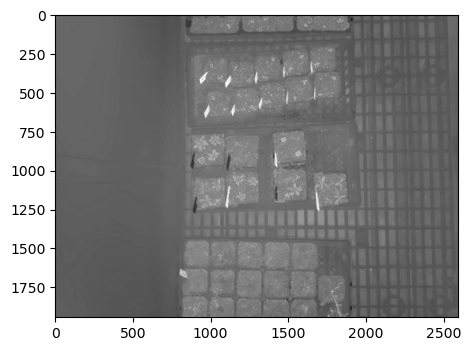

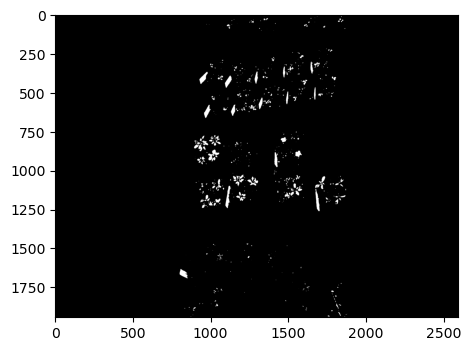

In [12]:
# Convert RGB to LAB and extract the blue channel ('b')

# Input:
#   rgb_img - RGB image data 
#   channel- Split by 'l' (lightness), 'a' (green-magenta), or 'b' (blue-yellow) channel
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')

# Threshold the blue channel image 
b_thresh = pcv.threshold.binary(gray_img=b, threshold=160, max_value=255, object_type='light')



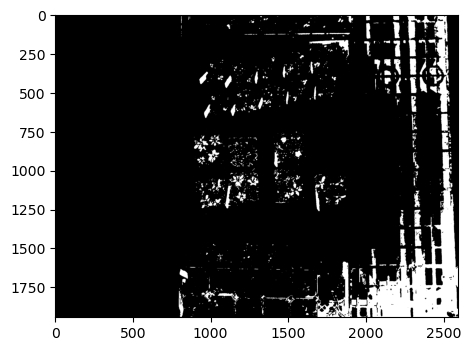

In [14]:
# Join the threshold saturation and blue-yellow images with a logical or operation 

# Inputs: 
#   bin_img1 - Binary image data to be compared to bin_img2
#   bin_img2 - Binary image data to be compared to bin_img1
bs = pcv.logical_or(bin_img1=s_mblur, bin_img2=b_thresh)


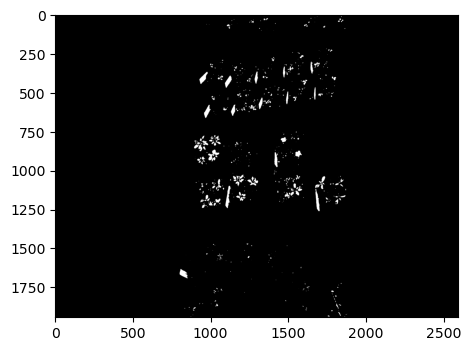

In [15]:
# Appy Mask (for VIS images, mask_color='white')

# Inputs:
#   img - RGB or grayscale image data 
#   mask - Binary mask image data 
#   mask_color - 'white' or 'black' 
masked = pcv.apply_mask(img=b_thresh, mask=bs, mask_color='black')


<IPython.core.display.Javascript object>


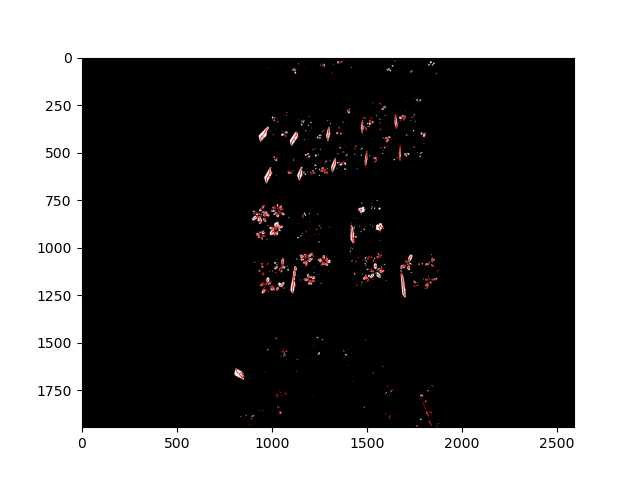

In [16]:
# Skeletonize the mask 
%matplotlib notebook
# To enable the zoom feature to better see fine lines, uncomment the line above ^^ 

# Inputs:
#   mask = Binary image data
skeleton = pcv.morphology.skeletonize(mask=masked)


In [17]:
# Adjust line thickness with the global line thickness parameter (default = 5),
    # and provide binary mask of the plant for debugging. NOTE: the objects and
    # hierarchies returned will be exactly the same but the debugging image (segmented_img)
    # will look different.
pcv.params.line_thickness = 3 

    # Prune the skeleton  

    # Inputs:
    #   skel_img = Skeletonized image
    #   size     = Pieces of skeleton smaller than `size` should get removed. (Optional) Default `size=0`. 
    #   mask     = Binary mask for debugging (optional). If provided, debug images will be overlaid on the mask.

pruned, seg_img, edge_objects = pcv.morphology.prune(skel_img=skeleton, size=10, mask=masked)
pcv.params.debug = "plot"
#help

In [30]:
# Identify branch points   

# Inputs:
#   skel_img = Skeletonized image
#   mask     = (Optional) binary mask for debugging. If provided, debug image will be overlaid on the mask.
branch_pts_mask = pcv.morphology.find_branch_pts(skel_img=skeleton, mask=masked)


In [31]:
# Identify tip points   

# Inputs:
#   skel_img = Skeletonized image
#   mask     = (Optional) binary mask for debugging. If provided, debug 
#              image will be overlaid on the mask.
tip_pts_mask = pcv.morphology.find_tips(skel_img=skeleton, mask=None)


In [18]:
# Adjust line thickness with the global line thickness parameter (default = 5),
# and provide binary mask of the plant for debugging. NOTE: the objects and
# hierarchies returned will be exactly the same but the debugging image (segmented_img)
# will look different.
pcv.params.line_thickness = 3 


In [20]:
# Sort segments into primary (stem) objects and secondary (leaf) objects. 
# Downstream steps can be performed on just one class of objects at a time, 
# or all objects (output from segment_skeleton) 
  
# Inputs:
#   skel_img  = Skeletonized image
#   objects   = List of contours
#   mask      = (Optional) binary mask for debugging. If provided, debug image will be overlaid on the mask.
leaf_obj, stem_obj = pcv.morphology.segment_sort(skel_img=skeleton, 
                                                 objects=edge_objects,
                                                 mask=masked)


In [22]:
# Identify segments     

# Inputs:
#   skel_img  = Skeletonized image
#   objects   = List of contours
#   mask      = (Optional) binary mask for debugging. If provided, 
#               debug image will be overlaid on the mask.
segmented_img, labeled_img = pcv.morphology.segment_id(skel_img=skeleton, objects=leaf_obj,
                                                       mask=masked)


In [24]:
# Similar to line thickness, there are optional text size and text thickness parameters 
# that can be adjusted to better suit images or varying sizes.
pcv.params.text_size=.8 # (default text_size=.55)
pcv.params.text_thickness=3 # (defaul text_thickness=2) 

segmented_img, labeled_img = pcv.morphology.segment_id(skel_img=skeleton,
                                                       objects=leaf_obj,
                                                       mask=masked)

In [25]:
# Measure path lengths of segments     

# Inputs:
#   segmented_img = Segmented image to plot lengths on
#   objects       = List of contours
labeled_img  = pcv.morphology.segment_path_length(segmented_img=segmented_img, 
                                                  objects=leaf_obj)


In [26]:
# Measure euclidean distance of segments      

# Inputs:
#   segmented_img = Segmented image to plot lengths on
#   objects       = List of contours
labeled_img = pcv.morphology.segment_euclidean_length(segmented_img=segmented_img, 
                                                      objects=leaf_obj)


RuntimeError: Too many tips found per segment, try pruning again

In [27]:
# Measure curvature of segments      

# Inputs:
#   segmented_img = Segmented image to plot curvature on
#   objects       = List of contours
labeled_img = pcv.morphology.segment_curvature(segmented_img=segmented_img, 
                                               objects=leaf_obj)


RuntimeError: Too many tips found per segment, try pruning again

In [ ]:
# Measure the angle of segments      

# Inputs:
#   segmented_img = Segmented image to plot angles on
#   objects       = List of contours
labeled_img = pcv.morphology.segment_angle(segmented_img=segmented_img, 
                                           objects=leaf_obj)


In [ ]:
# Measure the tangent angles of segments      

# Inputs:
#   segmented_img = Segmented image to plot tangent angles on
#   objects       = List of contours
#   size          = Size of ends used to calculate "tangent" lines
labeled_img = pcv.morphology.segment_tangent_angle(segmented_img=segmented_img, 
                                                   objects=leaf_obj, size=15)


In [ ]:
# Measure the leaf insertion angles      

# Inputs:
#   skel_img         = Skeletonize image 
#   segmented_img    = Segmented image to plot insertion angles on
#   leaf_objects     = List of leaf contours
#   stem_objects     = List of stem objects 
#   size             = Size of the inner portion of each leaf to find a linear regression line
labeled_img = pcv.morphology.segment_insertion_angle(skel_img=skeleton,
                                                     segmented_img=segmented_img, 
                                                     leaf_objects=leaf_obj, 
                                                     stem_objects=stem_obj,
                                                     size=20)


In [28]:
# Write morphological data to results file

# The print_results function will take the measurements stored when running any (or all) of these functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 
pcv.print_results(filename=args.result)
